# Description

Mean Field Inference for denoising binary images with Boltzmann Machines on MNIST data (http://yann.lecun.com/exdb/mnist/)

---

# Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy.special import expit
from ipywidgets import IntProgress

# Data

## Data loading

In [2]:
import torchvision
data_train = torchvision.datasets.MNIST('Data/mnist', train=True, transform=None, target_transform=None, download=True)
data_eval = torchvision.datasets.MNIST('Data/mnist', train=False, transform=None, target_transform=None, download=True)

train_images_raw = data_train.data.numpy()
train_labels = data_train.targets.numpy()
eval_images_raw = data_eval.data.numpy()
eval_labels = data_eval.targets.numpy()

np.savez('Data/mnist.npz', train_images_raw=train_images_raw, train_labels=train_labels, 
         eval_images_raw=eval_images_raw, eval_labels=eval_labels) 

## Treshold and noise

Function `get_thresholded_and_noised` does image thresholding and flipping pixels. More specifically, this functions exactly applys the following two steps in order:

1. **Thresholding**: First, given the input threshold argument, compute a thresholded image array. This array should indicate whether each element of `images_raw` is **greater than or equal to**  the `threshold` argument.
2. **Noise Application (i.e., Flipping Pixels)**: After the image was thresholded, use the `flip_flags` input argument and flip the pixels with a corresponding `True` entry in `flip_flags`. 
3. **Mapping Pixels to -1/+1**: Make sure the output image pixels are mapped to -1 and 1 values.

`get_thresholded_and_noised` takes the following arguments:

1. `images_raw`: A numpy array
2. `threshold`: A scalar value
3. `flip_flags`: A numpy array with the same shape as `images_raw` and `np.bool` dtype. This array indicates whether each pixel should be flipped or not.

and return the following:

* `mapped_noised_image`: A numpy array with the same shape as `images_raw`.  This array's entries should either be -1 or 1.

In [3]:
def get_thresholded_and_noised(images_raw, threshold, flip_flags):
    thresholded_image = images_raw >= threshold
    noise_image = np.logical_xor(thresholded_image, flip_flags)
    mapped_noised_image = np.where(noise_image, 1, -1)
    
    return mapped_noised_image.astype(np.int32)

### Apply

In [4]:
noise_flip_prob = 0.04

In [5]:
X_true_grayscale = train_images_raw[:10, :, :]

np_random = np.random.RandomState(seed=12345)
flip_flags = flip_flags = (np_random.uniform(0., 1., size=X_true_grayscale.shape) < noise_flip_prob)
initial_pi = np_random.uniform(0, 1, size=X_true_grayscale.shape) # Initial Random Pi values

X_true = get_thresholded_and_noised(X_true_grayscale, threshold=128, flip_flags=flip_flags * 0)
X_noised = get_thresholded_and_noised(X_true_grayscale, threshold=128, flip_flags=flip_flags)

### Vizualise

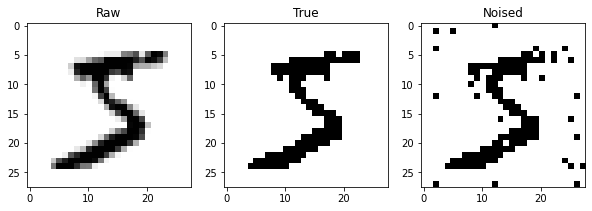

In [6]:
sample_raw_image = X_true_grayscale[0]
sample_true_image = X_true[0]
sample_noised_image = X_noised[0]

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 3, 1)
plt.title("Raw")
plt.imshow(sample_raw_image, cmap='binary')
fig.add_subplot(1, 3, 2)
plt.title("True")
plt.imshow(sample_true_image, cmap='binary')
fig.add_subplot(1, 3, 3)
plt.title("Noised")
plt.imshow(sample_noised_image, cmap='binary')
plt.show()

Funciton named `sigmoid_2x` given a variable $X$ computes the following:

$$f(X) := \frac{\exp(X)}{\exp(X) + \exp(-X)}$$

The input argument is a numpy array $X$.

**Important Note**: Theoretically, $f$ satisfies the following equations:

$$\lim_{X\rightarrow +\infty} f(X) = 1$$
$$\lim_{X\rightarrow -\infty} f(X) = 0$$

So it must also work correctly even on these extreme edge cases

In [7]:
def sigmoid_2x(X):
    output = expit(2*X)
    
    return output

# Applying Mean-field Approximation to Boltzman Machine's Variational Inference Problem

`boltzman_meanfield` function applies the mean-field approximation to the Boltzman machine. 

$X_i$ is the observed value of pixel $i$, and $H_i$ is the true value of pixel $i$ (before applying noise). For instance, if we have a $3 \times 3$ image, the corresponding Boltzman machine looks like this: 

```
       X_1        X_2        X_3
      /          /          /
     H_1 ------ H_2 ------ H_3
      |          |          |
      |          |          |
      |          |          |
      | X_4      | X_5      | X_6
      |/         |/         |/ 
     H_4 ------ H_5 ------ H_6
      |          |          |
      |          |          |
      |          |          |
      | X_7      | X_8      | X_9
      |/         |/         |/ 
     H_7 ------ H_8 ------ H_9
```     

Here, I a adopt a slightly simplified notation and define $\mathcal{N}(i)$ to be the neighbors of pixel $i$ (the pixels adjacent to pixel $i$). For instance, in the above figure, we have $\mathcal{N}(1) = \{2,4\}$, $\mathcal{N}(2) = \{1,3,5\}$, and $\mathcal{N}(5) = \{2,4,6,8\}$.


With this, the process can be summarized as follows:

```
1. for iteration = 1, 2, 3, ....,
  2. Pick a random pixel i.
  3. Find pixel i's new parameter as
```
$$\pi_i^{\text{new}} = \frac{\exp(\theta_{ii}^{(2)} X_i + \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1))}{\exp(\theta_{ii}^{(2)} X_i + \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1)) + \exp(-\theta_{ii}^{(2)} X_i - \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1))} .$$
```
  4. Replace the existing parameter for pixel i with the new one.
```
$$\pi_i \leftarrow \pi_i^{\text{new}}$$

Since computational resources are extremely vectorized, I will make the following minor algorithmic modification and implement the following instead:

```
1. for iteration = 1, 2, 3, ....,
  2. for each pixels i:
  3. Find pixel i's new parameter, but do not update the original parameter yet.
```
$$\pi_i^{\text{new}} = \frac{\exp(\theta_{ii}^{(2)} X_i + \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1))}{\exp(\theta_{ii}^{(2)} X_i + \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1)) + \exp(-\theta_{ii}^{(2)} X_i - \sum_{j\in \mathcal{N}(i)} \theta_{ij}^{(1)} (2\pi_j -1))} .$$
```
  4. Once computed all new parameters, I need to update all of them at the same time:
```
$$\pi \leftarrow \pi^{\text{new}}$$

We assume that the parameters $\theta_{ii}^{(2)}$ have the same value for all $i$ and denote their common value by scalar `theta_X`. Moreover, we assume that the parameters $\theta_{ij}^{(1)}$ have the same value for all $i,j$ and denote their common value by scalar `theta_pi`.

The `boltzman_meanfield` function takes the following input arguments:
1. `images`: A numpy array with the shape `(N,height,width)`, where 
    * `N` is the number of samples and could be anything,
    * `height` is each individual image's height in pixels (i.e., number of rows in each image),
    * and `width` is each individual image's width in pixels (i.e., number of columns in each image).
      * The entries of `images` are either -1 or 1.
2. `initial_pi`: A numpy array with the same shape as `images` (i.e. `(N,height,width)`). This variable is corresponding to the initial value of $\pi$ in the above equations.
3. `theta_X`: A scalar with a default value of `0.5*np.log(1/noise_flip_prob-1)`. This variable represents $\theta_{ii}^{(2)}$ in the above update equation.
4. `theta_pi`: A scalar with a default value of 2. This variable represents $\theta_{ij}^{(1)}$ in the above update equation.
5. `iterations`: A scalar with a default value of 100. This variable denotes the number of update iterations to perform.

The `boltzman_meanfield` function returns the final $\pi$ variable as a numpy array called `pi`, and should contain values that are between 0 and 1. 

In [8]:
def boltzman_meanfield(images, initial_pi, theta_X=0.5*np.log(1/noise_flip_prob-1), theta_pi=2, iterations=100):
    if len(images.shape)==2:
        X = images.reshape(1,*images.shape)
    else:
        X = images[0]
        
    pi = initial_pi
    
    for iteration in range(iterations):
        f1 = theta_X * images
        
        left = theta_pi * np.where(np.pad(pi, ((0,0), (0,0), (1,0)), mode='constant')[:, :, :-1]==0, np.pad(pi, ((0,0), (0,0), (1,0)), mode='constant')[:, :, :-1], 2 * np.pad(pi, ((0,0), (0,0), (1,0)), mode='constant')[:, :, :-1] - 1)
        right = theta_pi * np.where(np.pad(pi, ((0,0), (0,0), (0,1)), mode='constant')[:, :, 1:]==0, np.pad(pi, ((0,0), (0,0), (0,1)), mode='constant')[:, :, 1:], 2 * np.pad(pi, ((0,0), (0,0), (0,1)), mode='constant')[:, :, 1:] - 1)
        top = theta_pi * np.where(np.pad(pi, ((0,0), (1,0), (0,0)), mode='constant')[:, :-1, :]==0, np.pad(pi, ((0,0), (1,0), (0,0)), mode='constant')[:, :-1, :], 2 * np.pad(pi, ((0,0), (1,0), (0,0)), mode='constant')[:, :-1, :] - 1)
        bottom = theta_pi * np.where(np.pad(pi, ((0,0), (0,1), (0,0)), mode='constant')[:, 1:, :]==0, np.pad(pi, ((0,0), (0,1), (0,0)), mode='constant')[:, 1:, :], 2 * np.pad(pi, ((0,0), (0,1), (0,0)), mode='constant')[:, 1:, :] - 1)
        
        f2 = left + right + top + bottom
        f3 = f1 + f2
        pi = sigmoid_2x(f3)
    return pi.reshape(*images.shape)

## Vizualise

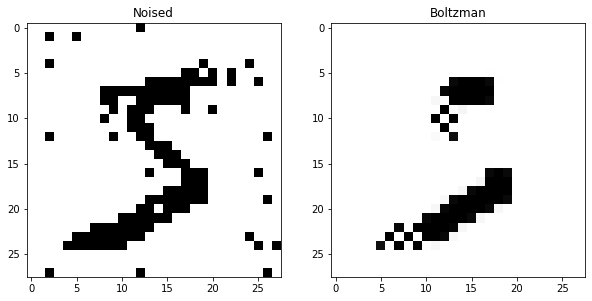

In [9]:
def test_boltzman(x, seed = 12345, theta_X=0.5*np.log(1/noise_flip_prob-1), theta_pi=2, iterations=100):        
    np_random = np.random.RandomState(seed=seed)
    initial_pi = np_random.uniform(0,1, size=x.shape)
    return boltzman_meanfield(x, initial_pi, theta_X=theta_X, theta_pi=theta_pi, iterations=iterations)

sample_noised_image = X_noised[0]
sample_boltzman_image = test_boltzman(X_noised)[0]

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.title("Noised")
plt.imshow(sample_noised_image, cmap='binary')
fig.add_subplot(1, 2, 2)
plt.title("Boltzman")
plt.imshow(sample_boltzman_image, cmap='binary')
plt.show()

# Tuning the Boltzman Machine's Hyper-Parameters

With the `boltzman_meanfield` function implemented above, lets see the effect of changing hyper parameters `theta_X` and `theta_pi`

For each value of `theta_pi`, I apply the denoising and compare the denoised images to the original ones. I adopt several statistical measures to compare original and denoised images and to finally decide which value of `theta_pi` is better. 

Let `P` be the total number of pixels that was fliped during the noise adding process, and `N` be the total number of pixels that was not fliped during the noise adding process. We can define:

- True Positive (`TP`). Defined to be the total number of pixels that are flipped during the noise adding process, and we successfully detect them during the denoising process. 
- True Positive Rate (`TPR`). Other names: sensitivity, recall. Defined to be the ratio `TP / P`.
- False Positive (`FP`). Defined to be the number of pixels that were detected as being noisy during the denosing process, but were not really noisy. 
- False Positive Rate (`FPR`). Other name: fall-out. Defined to be the ratio `FP/N`.
- Positive Predictive Value (`PPV`). Other name: precision. Defined to be the ratio `TP / (TP + FP)`.
- `F1` score. Defined to be the harmonic mean of precision (`PPV`) and recall (`TPR`), or equivalently `2 TP / (2 TP + FP + FN)`. 

In [10]:
def get_tpr(preds, true_labels):
    TP = (preds * (preds == true_labels)).sum()
    P = true_labels.sum()
    if P==0:
        TPR = 1.
    else:
        TPR = TP / P
    
    return TPR

def get_fpr(preds, true_labels):
    FP = (preds * (preds != true_labels)).sum()
    N = (1-true_labels).sum()
    if N==0:
        FPR=1
    else:
        FPR = FP / N
    return FPR

def get_ppv(preds, true_labels):
    TP = (preds * (preds == true_labels)).sum()
    FP = (preds * (preds != true_labels)).sum()
    if (TP + FP) == 0:
        PPV = 1
    else:
        PPV = TP / (TP + FP)
    return PPV

def get_f1(preds, true_labels):
    TP = (preds * (preds == true_labels)).sum()
    FP = (preds * (preds != true_labels)).sum()
    FN = ((1-preds) * (preds != true_labels)).sum()
    if (2 * TP + FP + FN) == 0:
        F1 = 1
    else:
        F1 = (2 * TP) / (2 * TP + FP + FN)
    return F1

## Apply

In [11]:
all_theta = np.arange(0, 10, 0.2).tolist() + np.arange(10, 100, 5).tolist()

tpr_list, fpr_list, ppv_list, f1_list = [], [], [], []

for theta in all_theta:
    meanfield_pi = boltzman_meanfield(X_noised, initial_pi, theta_X=0.5*np.log(1/noise_flip_prob-1), theta_pi=theta, iterations=100)
    X_denoised = 2 * (meanfield_pi > 0.5) - 1

    predicted_noise_pixels = (X_denoised != X_noised)
    tpr = get_tpr(predicted_noise_pixels, flip_flags)
    fpr = get_fpr(predicted_noise_pixels, flip_flags)
    ppv = get_ppv(predicted_noise_pixels, flip_flags)
    f1 = get_f1(predicted_noise_pixels, flip_flags)

    tpr_list.append(tpr)
    fpr_list.append(fpr)
    ppv_list.append(ppv)
    f1_list.append(f1)

## Vizualise

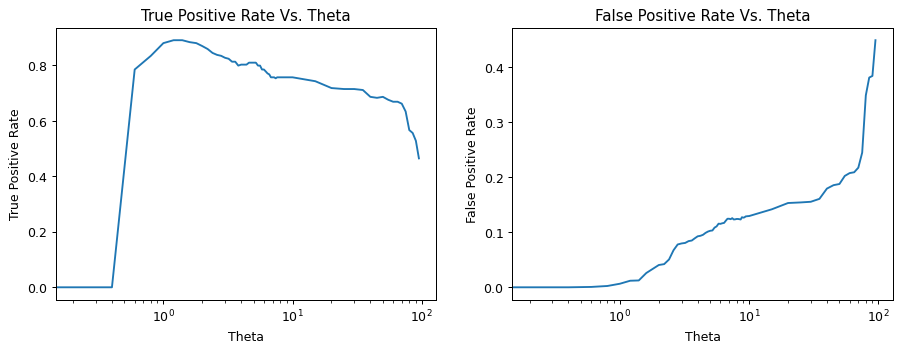

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=90)

ax=axes[0]
ax.plot(all_theta, tpr_list)
ax.set_xlabel('Theta')
ax.set_ylabel('True Positive Rate')
ax.set_title('True Positive Rate Vs. Theta')
ax.set_xscale('log')

ax=axes[1]
ax.plot(all_theta, fpr_list)
ax.set_xlabel('Theta')
ax.set_ylabel('False Positive Rate')
ax.set_title('False Positive Rate Vs. Theta')
ax.set_xscale('log')

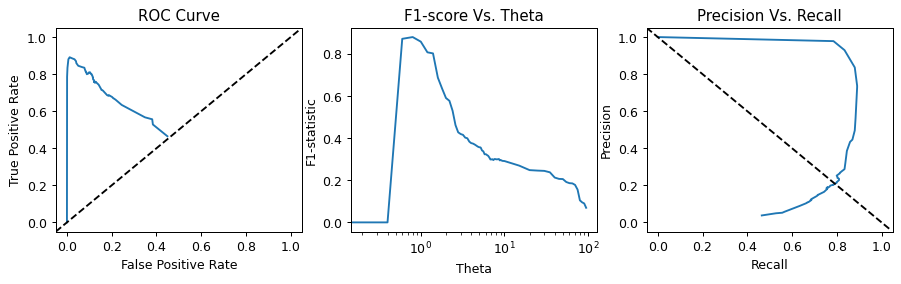

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3), dpi=90)

ax=axes[0]
ax.plot(fpr_list, tpr_list)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.plot(np.arange(-0.05, 1.05, 0.01), np.arange(-0.05, 1.05, 0.01), ls='--', c='black')

ax=axes[1]
ax.plot(all_theta, f1_list)
ax.set_xlabel('Theta')
ax.set_ylabel('F1-statistic')
ax.set_title('F1-score Vs. Theta')
ax.set_xscale('log')

ax=axes[2]
ax.plot(tpr_list, ppv_list)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Vs. Recall')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.plot(np.arange(-0.05, 1.05, 0.01), 1-np.arange(-0.05, 1.05, 0.01), ls='--', c='black')
None

In [14]:
best_theta = all_theta[np.argmax(f1_list)]
print(f'Best theta w.r.t. the F-score is {best_theta}')

Best theta w.r.t. the F-score is 0.8


Now let's try the tuned hyper-parameters, and verify whether it visually improved the Boltzman machine.

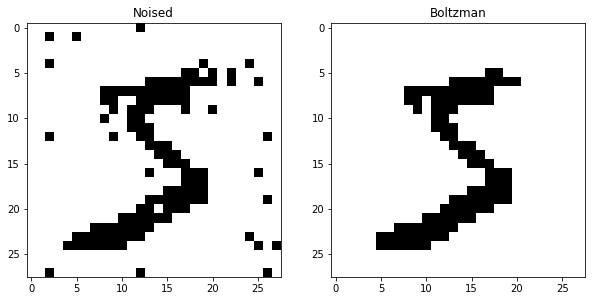

In [15]:
def test_boltzman(x, seed = 12345, theta_X=0.5*np.log(1/noise_flip_prob-1), theta_pi=best_theta, iterations=100):        
        np_random = np.random.RandomState(seed=seed)
        initial_pi = np_random.uniform(0,1, size=x.shape)
        return boltzman_meanfield(x, initial_pi, theta_X=theta_X, theta_pi=theta_pi, iterations=iterations) >  0.5

sample_noised_image = X_noised[0]
sample_boltzman_image = test_boltzman(X_noised)[0]

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.title("Noised")
plt.imshow(sample_noised_image, cmap='binary')
fig.add_subplot(1, 2, 2)
plt.title("Boltzman")
plt.imshow(sample_boltzman_image, cmap='binary')
plt.show()